https://medium.com/@jonathan_hui/rl-policy-gradients-explained-9b13b688b146

https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium

In [2]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [3]:
def set_seed(seed):
    """Sets the seed for reproducibility across different libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True # Ensures deterministic CUDA convolution algorithms
        torch.backends.cudnn.benchmark = False # Disables benchmarking for deterministic behavior

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

In [6]:
def train_episode(env, policy, optimizer, gamma, device):
    """Train policy for one episode."""
    policy.train()
    log_prob_actions, rewards = [], []
    done = False
    state, _ = env.reset()
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_logits = policy(state_tensor)
        action_prob = F.softmax(action_logits, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        rewards.append(reward)
        state = next_state
        
    log_prob_actions = torch.stack(log_prob_actions)
    returns = calculate_returns(rewards, gamma, device, False)
    loss = update_policy(returns, log_prob_actions, optimizer)
    return loss, sum(rewards)

In [7]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [8]:
def update_policy(returns, log_prob_actions, optimizer):
    """Compute loss and update policy parameters."""
    loss = -(returns * log_prob_actions).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits = policy(state_tensor)
            action = torch.argmax(action_logits, dim=-1).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state

    return total_reward

In [10]:
# ----------------------------
# Main experiment
# ----------------------------
train_env = gymnasium.make('CartPole-v1')
test_env = gymnasium.make('CartPole-v1')

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device_ = get_device()

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

max_episodes = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

policy_ = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device_)
policy_.apply(init_weights)

LEARNING_RATE = 0.001
optimizer_ = optim.Adam(policy_.parameters(), lr = LEARNING_RATE)

train_rewards = []
test_rewards = []

for episode in range(1, max_episodes+1):
    loss, train_reward = train_episode(train_env, policy_, optimizer_, DISCOUNT_FACTOR, device_)
    test_reward = evaluate(test_env, policy_, device_)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break
        
print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')


Using device: cuda
| Episode:  10 | Mean Train Rewards:  22.3 | Mean Test Rewards:   9.7 |
| Episode:  20 | Mean Train Rewards:  19.9 | Mean Test Rewards:   9.3 |
| Episode:  30 | Mean Train Rewards:  18.5 | Mean Test Rewards:   9.2 |
| Episode:  40 | Mean Train Rewards:  18.8 | Mean Test Rewards:   9.2 |
| Episode:  50 | Mean Train Rewards:  19.8 | Mean Test Rewards:  12.2 |
| Episode:  60 | Mean Train Rewards:  21.9 | Mean Test Rewards:  27.9 |
| Episode:  70 | Mean Train Rewards:  21.0 | Mean Test Rewards:  42.0 |
| Episode:  80 | Mean Train Rewards:  22.4 | Mean Test Rewards:  53.6 |
| Episode:  90 | Mean Train Rewards:  21.6 | Mean Test Rewards:  68.0 |
| Episode: 100 | Mean Train Rewards:  23.0 | Mean Test Rewards:  82.6 |
| Episode: 110 | Mean Train Rewards:  24.4 | Mean Test Rewards:  89.8 |
| Episode: 120 | Mean Train Rewards:  30.6 | Mean Test Rewards:  78.5 |
| Episode: 130 | Mean Train Rewards:  31.0 | Mean Test Rewards:  64.0 |
| Episode: 140 | Mean Train Rewards:  30.8 | 

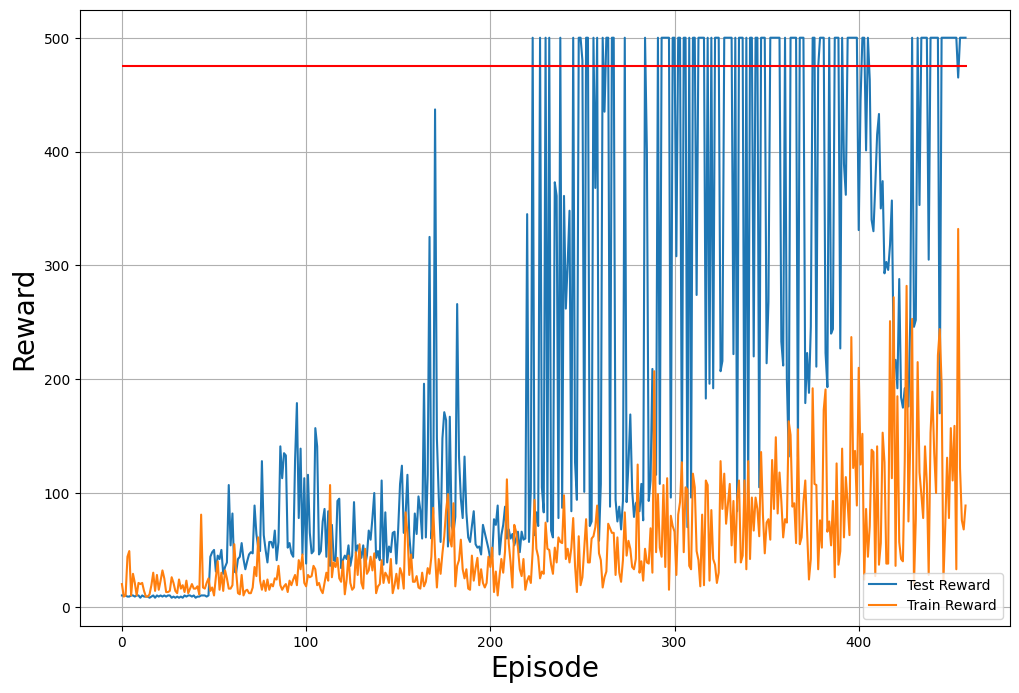

In [11]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()